In [4]:
from nibabel import load, save, Nifti1Image
from numpy import absolute

analysis = ['irritability']

home = '/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/'

for a in analysis:
    file = home + 'svrweights_%s.nii.gz' % a
    temp_nii = load(file)
    temp_data = temp_nii.get_data()
    new_data = absolute(temp_data)
    new_nii = Nifti1Image(new_data,header=temp_nii.header,affine=temp_nii.affine)
    new_file = home + 'svmABSweights_%s.nii.gz' % a
    save(new_nii,new_file)

In [5]:
from nipype.interfaces.fsl import Cluster

analysis = ['irritability']

for a in analysis:
    file = home + 'svmABSweights_%s.nii.gz' % a
    cl = Cluster()
    cl.inputs.in_file = file
    cl.inputs.out_localmax_txt_file = home + 'cluster_stats_%s.txt' % a
    cl.inputs.threshold = 0.000001
    cl.inputs.out_index_file = home + 'clusters_%s.nii.gz' % a
    cl.run()

181121-08:34:10,815 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:Cluster Index	Voxels	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
181121-08:34:10,819 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:46	29719	0.00123	179	91	140	178	95.7	151
181121-08:34:10,820 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:45	20453	0.00183	100	67	163	70.6	100	149
181121-08:34:10,822 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:44	11462	0.00151	79	169	141	85.6	174	154
181121-08:34:10,823 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:43	2516	0.000979	120	199	143	124	188	165
181121-08:34:10,824 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:42	1573	0.000842	150	193	153	151	184	164
181121-08:34:10,825 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:41	780	0.00135	112	201	144	111	203	143
181121-08:34:10,827 interface INFO:
	 stdout 2018-11-21T08:34:10.815619:40	386	0.000605	147	205	138	147	202	139
181121-08:34:10,827 interface INFO:
	 stdou

In [6]:

def extract_cluster_betas(cluster_index_file, sample_betas, min_clust_size, subject_ids):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, zeros_like, invert
    from nipype.interfaces.fsl.utils import ImageMeants
    from os.path import abspath, basename
    
    subject_ids = sorted(subject_ids)
    sample_data = DataFrame(subject_ids, index=None, columns=['Subject'])
    
    cluster_nifti = load(cluster_index_file)
    cluster_data = cluster_nifti.get_data()
    clusters, cluster_sizes = unique(cluster_data, return_counts=True)
    cluster_sizes = cluster_sizes[clusters>min_clust_size]
    clusters = clusters[clusters>min_clust_size]
    ind_filename = basename(cluster_index_file) 
    out_prefix = ind_filename[:-7]
    
    for clust_idx in clusters:
        temp = zeros_like(cluster_data)
        temp[cluster_data==clust_idx] = 1
        temp_nii = Nifti1Image(temp,cluster_nifti.affine)
        temp_file = 'temp_clust_mask.nii.gz'
        save(temp_nii, temp_file)

        eb = ImageMeants()
        eb.inputs.in_file = sample_betas
        eb.inputs.mask = temp_file
        eb.inputs.out_file = 'values.txt'
        eb.run()
        betas = open('values.txt').read().splitlines()
        sample_data['clust' + str(clust_idx)] = Series(betas, index=sample_data.index)
    
    sample_data.to_csv(out_prefix+'_extracted_values.csv')
    extracted_betas_csv = abspath(out_prefix+'_extracted_values.csv')
    
    print('###### ' + out_prefix + ' #######')
    print('cluster labels: '+str(clusters))
    print('cluster sizes: '+str(cluster_sizes))
    return(extracted_betas_csv)

In [8]:
from glob import glob
from pandas import read_csv
index_files = glob(home + 'clusters_*.nii.gz')
sample_betas = home + 'gmd_combined.nii.gz'
subject_info = read_csv(home + 'featureset_key.csv',index_col=0)

subject_ids = subject_info['subject']
min_clust_size = 25

for clusters in index_files:
    extract_cluster_betas(clusters, sample_betas, min_clust_size, subject_ids)

###### clusters_irritability #######
cluster labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
cluster sizes: [    1     1     1     1     1     2     3     7    10    10    11    11
    12    12    14    15    21    35    37    39    40    41    43    49
    51    56    72    74    84    94    99   102   124   151   203   230
   244   333   380   386   780  1573  2516 11462 20453 29719]


In [9]:

def get_cluster_peaks(clusters_file, stat_file):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, unravel_index, max
    
    # load up clusters
    clusters_nii = load(clusters_file)
    clusters_data = clusters_nii.get_data()
    cluster_labels, cluster_sizes = unique(clusters_data, return_counts=True)
    cluster_sizes = cluster_sizes[cluster_labels>0]
    cluster_labels = cluster_labels[cluster_labels>0]
    
    # set up dataframe
    cluster_info = DataFrame(columns=['clust_num','peak','num_voxels','X','Y','Z'])
    cluster_info['clust_num'] = Series(cluster_labels,index=None)
    
    for i in range(0,len(cluster_labels)):
        # load up stat image
        stat_nii = load(stat_file)
        stat_data = stat_nii.get_data()
        stat_data[clusters_data!=cluster_labels[i]]=0
        location=unravel_index(stat_data.argmax(), stat_data.shape)
        cluster_info.iloc[i,0]=cluster_labels[i]
        cluster_info.iloc[i,1]=max(stat_data)
        cluster_info.iloc[i,2]=cluster_sizes[i]
        cluster_info.iloc[i,3]=location[0]
        cluster_info.iloc[i,4]=location[1]
        cluster_info.iloc[i,5]=location[2]
    
    out_prefix = clusters_file[:-7]
    cluster_info.to_csv(out_prefix + '_peaks.csv')
    return(cluster_info)

In [10]:
cluster_files = [home + 'clusters_irritability.nii.gz']

stat_files=[home + 'svrweights_irritability.nii.gz']

for j in range(0,len(cluster_files)):
    get_cluster_peaks(cluster_files[j], stat_files[j])

In [25]:
from pandas import read_csv, DataFrame, merge
study_home = '/moochie/Cat/Aggregate_anats/GMD_ML'
sub_data_file = study_home + '/doc/subjectinfo.csv'

subject_info = read_csv(sub_data_file, index_col=None)
cluster_info = read_csv('/moochie/Cat/Aggregate_anats/GMD_ML/ml_trainingset/clusters_irritability_extracted_values.csv',index_col=0)

new = subject_info.merge(cluster_info, left_on='Subject', right_on='Subject')
new.columns


Index(['Subject', 'Study', 'SequenceVersion', 'PotentiallyUsable',
       'in_analysis', 'Dx_Group', 'Age_yrs', 'Age_mos', 'male', 'cbq_activity',
       'cbq_angfru', 'cbq_approach', 'cbq_attentionfocus', 'cbq_discomfort',
       'cbq_soothability', 'cbq_fear', 'cbq_hip', 'cbq_impulsivity',
       'cbq_inhibtctl', 'cbq_lip', 'cbq_perceptsens', 'cbq_sad', 'cbq_shy',
       'cbq_smilelaugh', 'map_temploss', 'clust1', 'clust2', 'clust3',
       'clust4', 'clust5', 'clust6', 'clust7', 'clust8', 'clust9', 'clust10',
       'clust11', 'clust12', 'clust13', 'clust14', 'clust15', 'clust16',
       'clust17', 'clust18', 'clust19', 'clust20', 'clust21', 'clust22',
       'clust23', 'clust24', 'clust25', 'clust26', 'clust27', 'clust28',
       'clust29', 'clust30', 'clust31', 'clust32', 'clust33', 'clust34',
       'clust35', 'clust36', 'clust37', 'clust38', 'clust39', 'clust40',
       'clust41', 'clust42', 'clust43', 'clust44', 'clust45', 'clust46'],
      dtype='object')

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

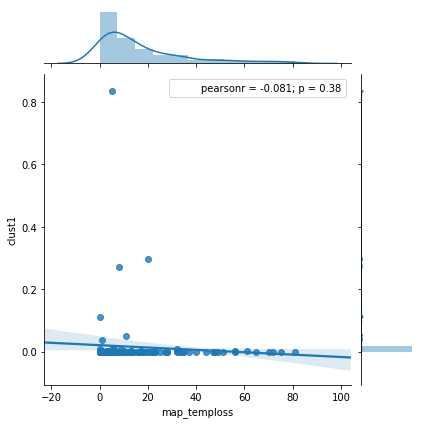

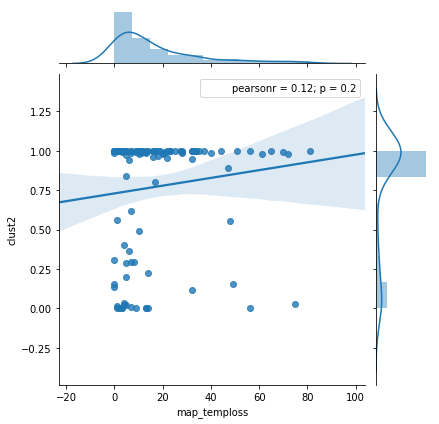

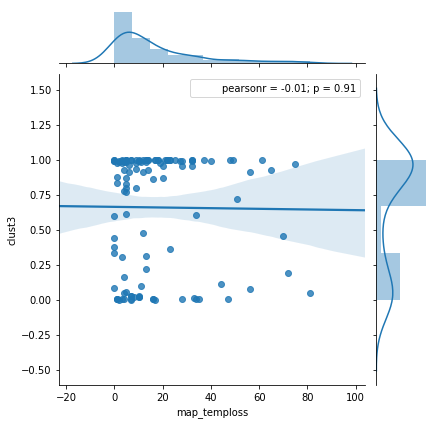

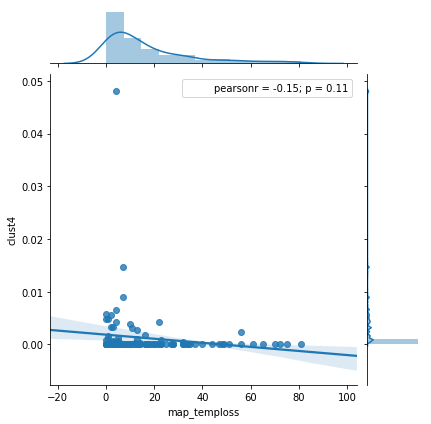

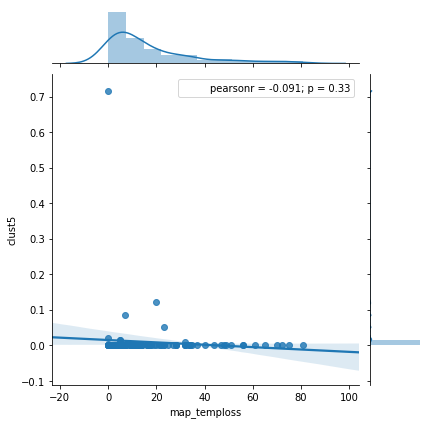

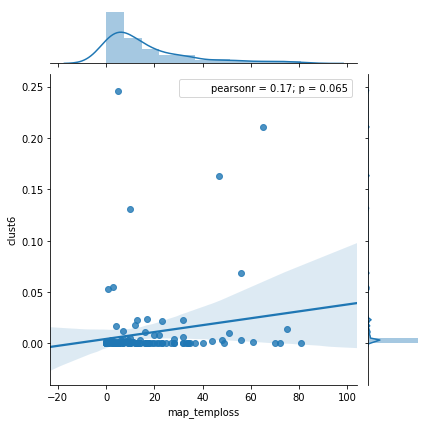

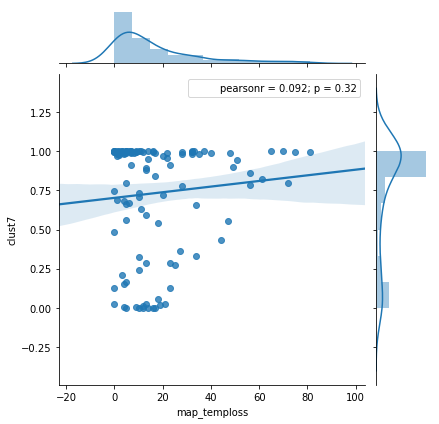

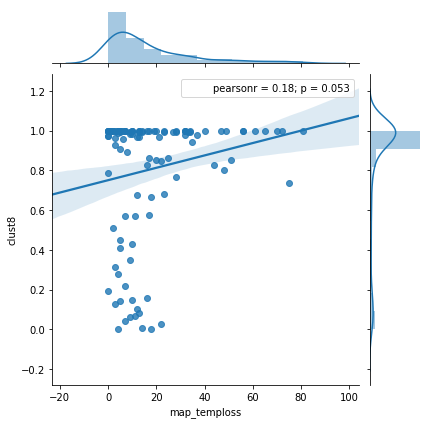

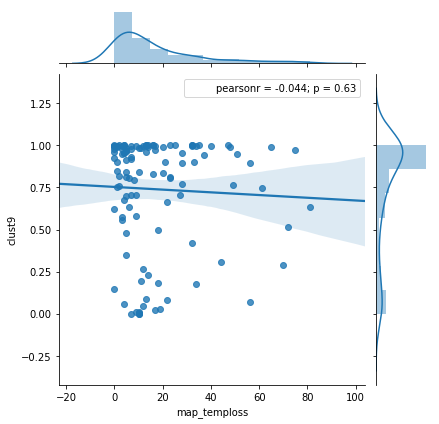

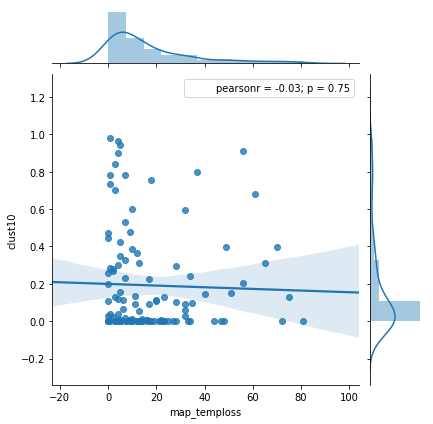

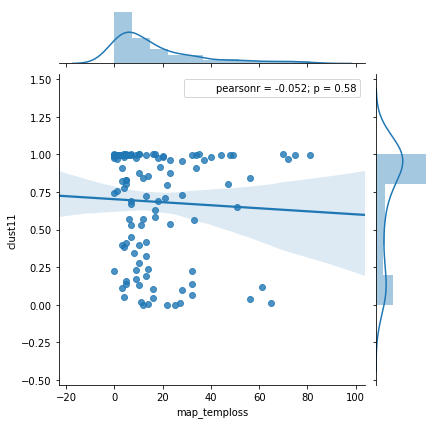

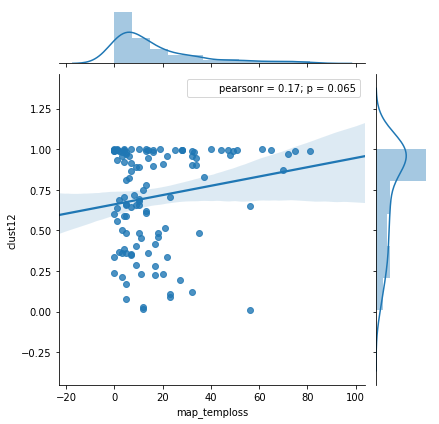

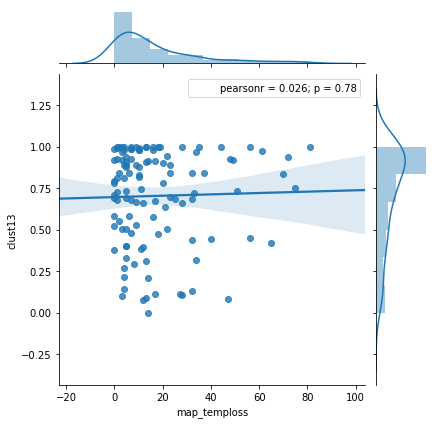

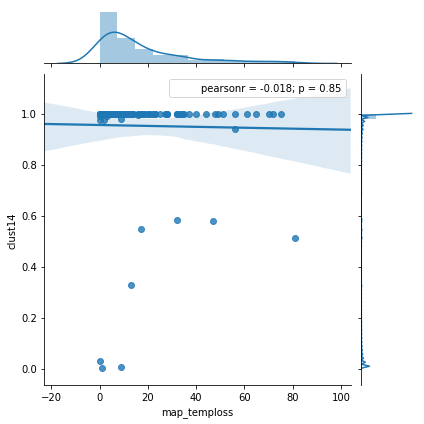

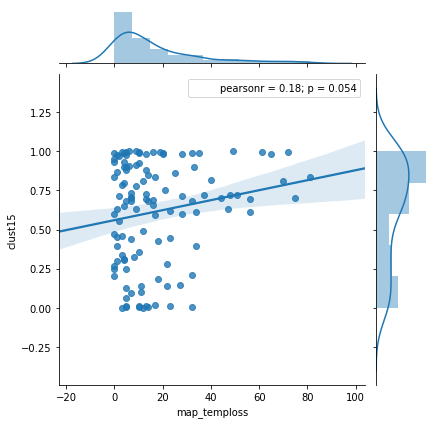

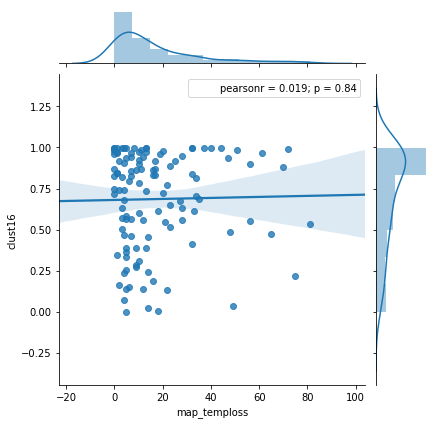

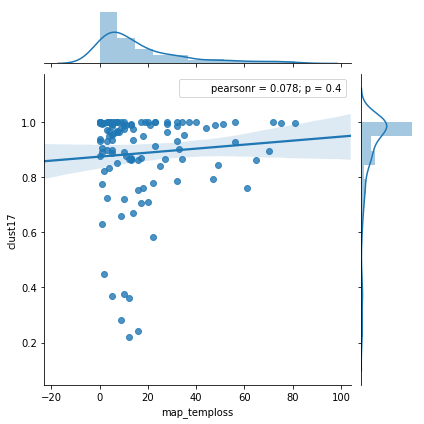

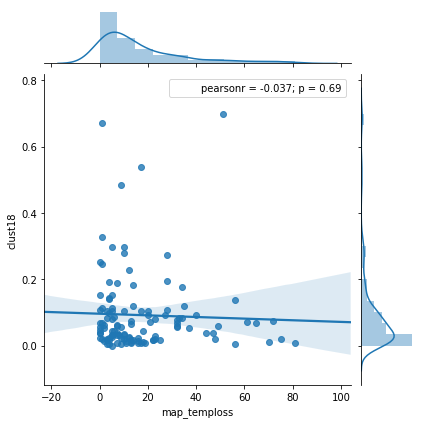

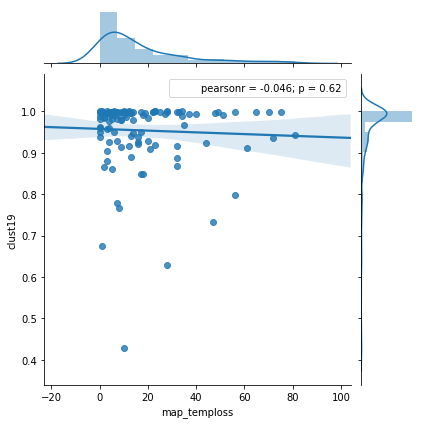

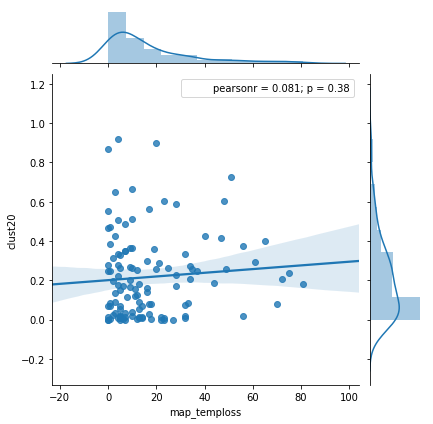

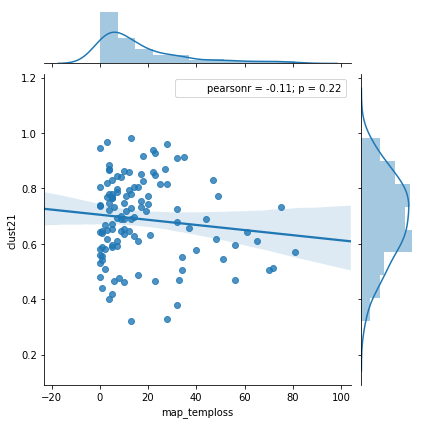

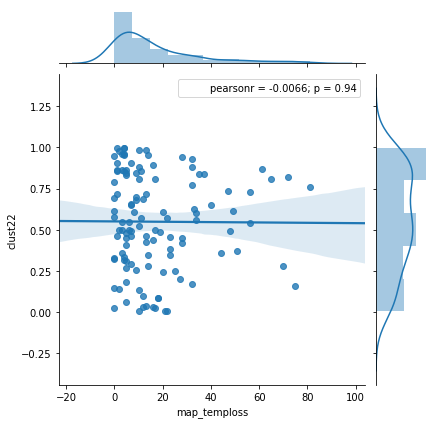

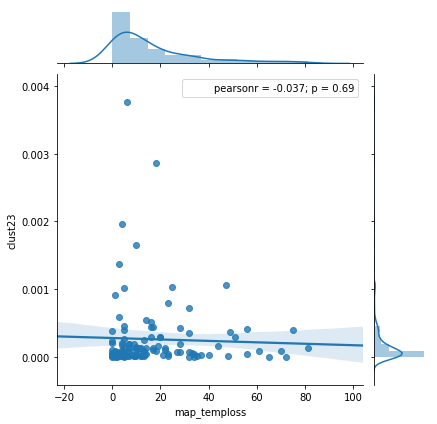

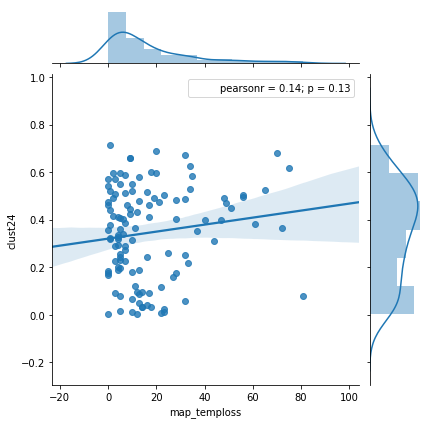

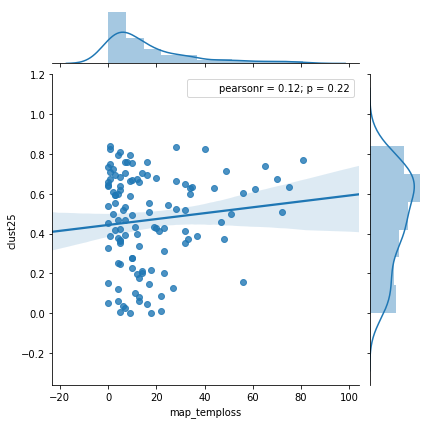

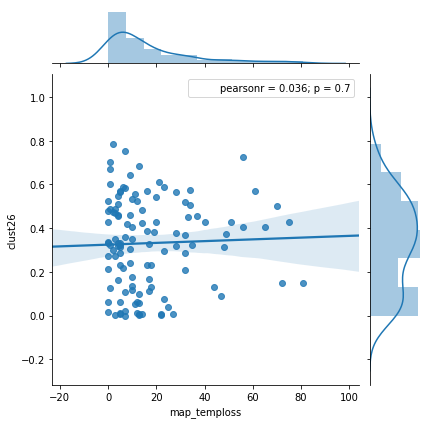

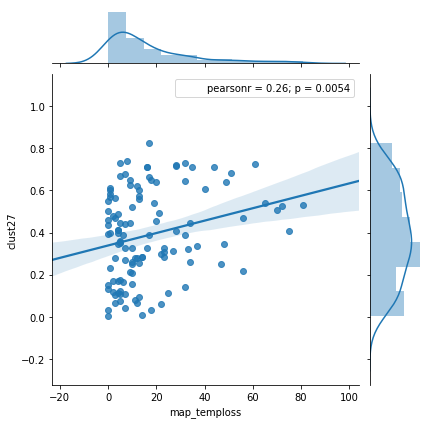

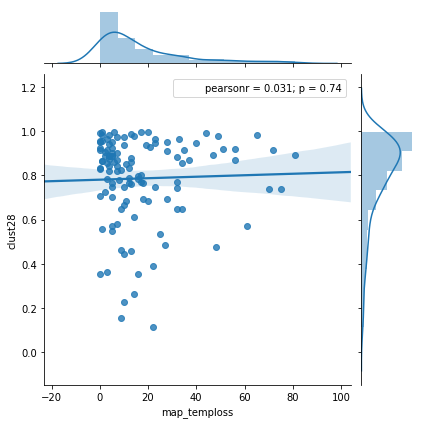

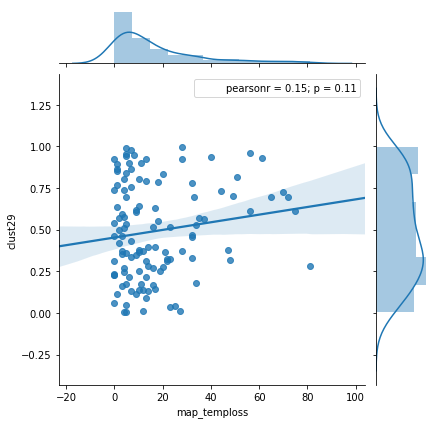

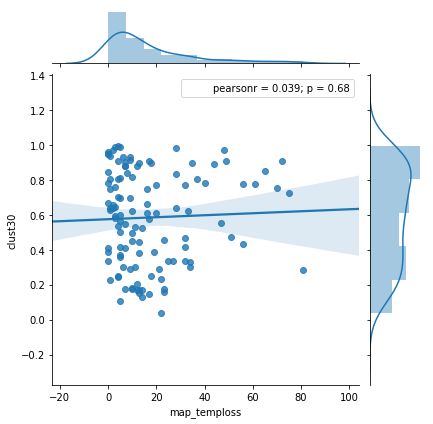

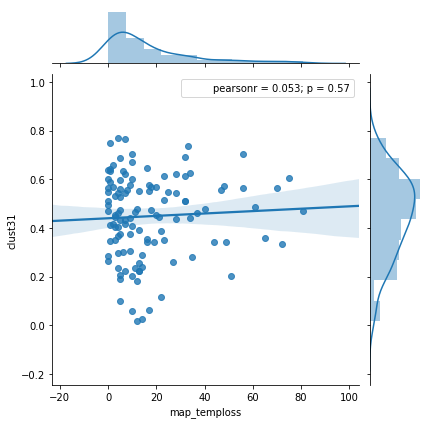

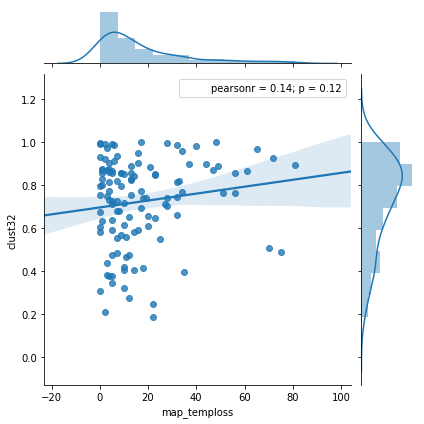

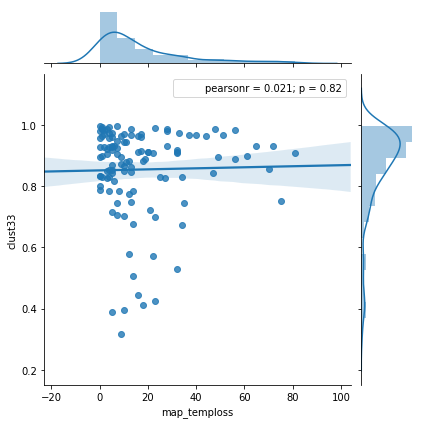

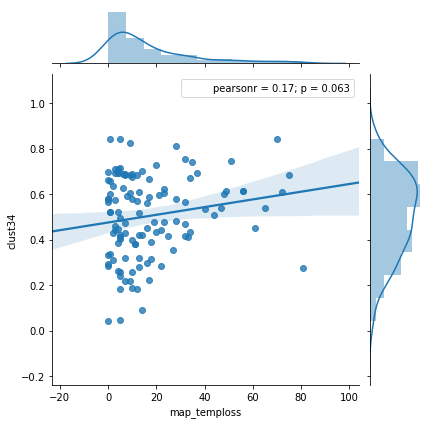

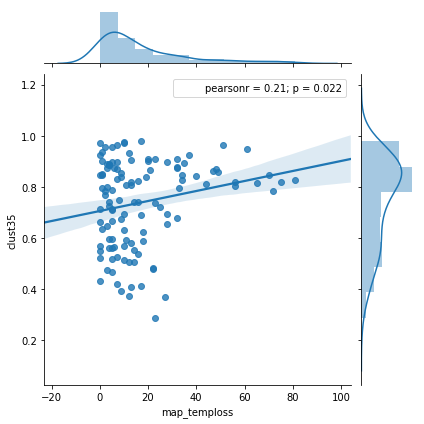

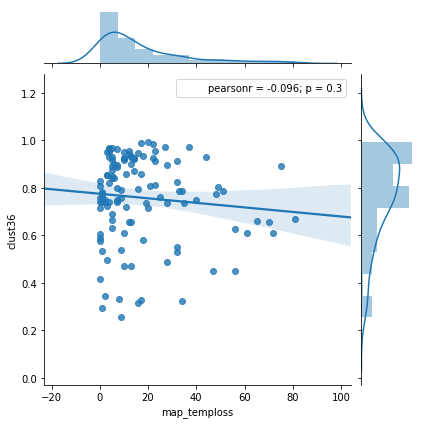

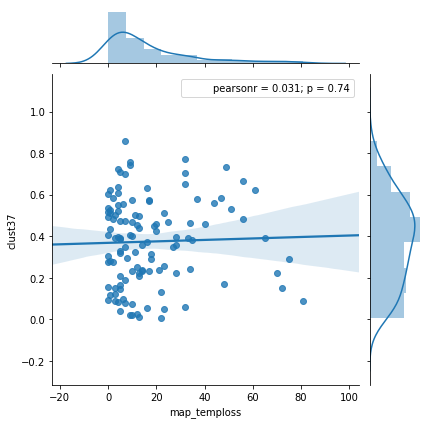

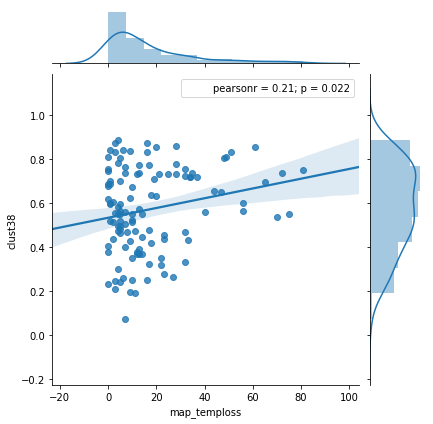

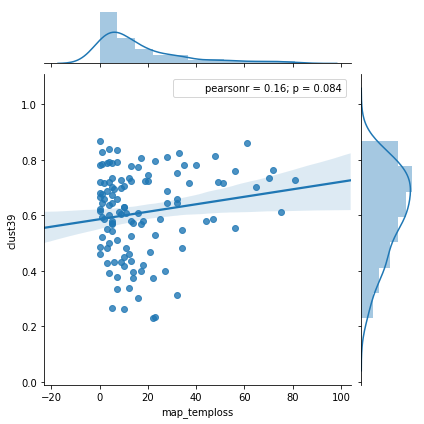

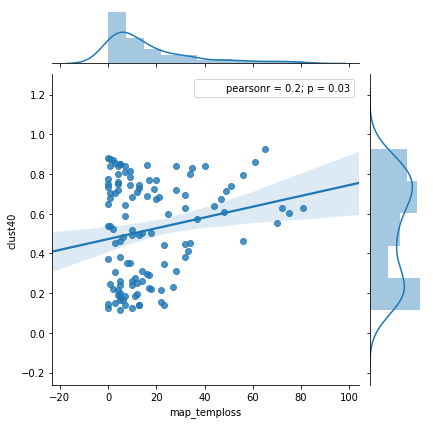

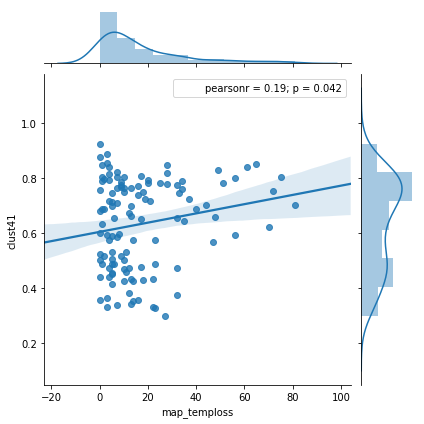

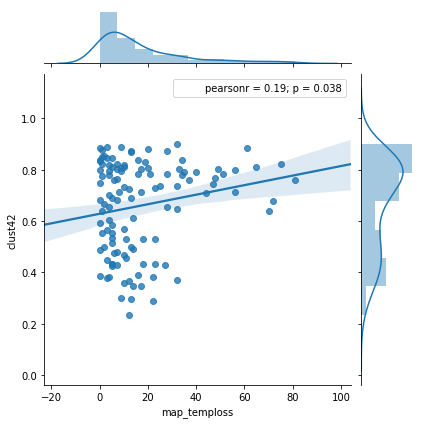

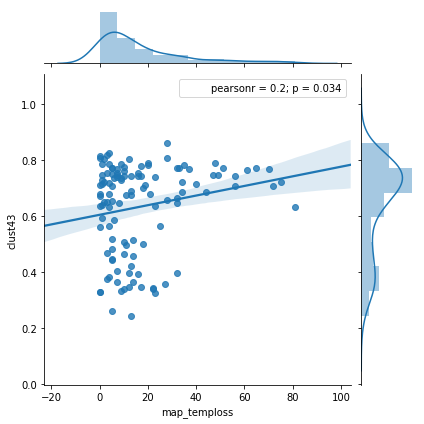

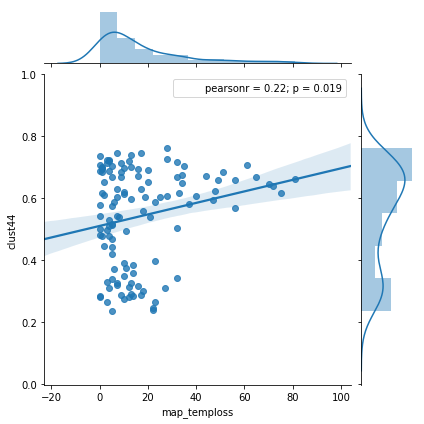

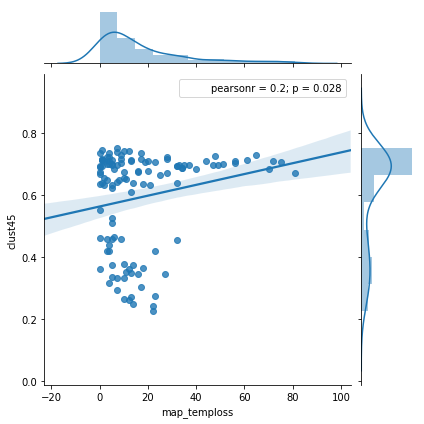

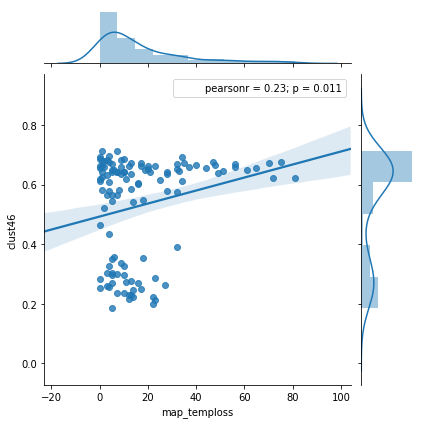

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

clusters = ['clust1', 'clust2', 'clust3',
       'clust4', 'clust5', 'clust6', 'clust7', 'clust8', 'clust9', 'clust10',
       'clust11', 'clust12', 'clust13', 'clust14', 'clust15', 'clust16',
       'clust17', 'clust18', 'clust19', 'clust20', 'clust21', 'clust22',
       'clust23', 'clust24', 'clust25', 'clust26', 'clust27', 'clust28',
       'clust29', 'clust30', 'clust31', 'clust32', 'clust33', 'clust34',
       'clust35', 'clust36', 'clust37', 'clust38', 'clust39', 'clust40',
       'clust41', 'clust42', 'clust43', 'clust44', 'clust45', 'clust46']
for cluster in clusters:
    sns.jointplot('map_temploss',cluster,data=new, kind='reg')
    